In [1]:
import pandas
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import pandas as pd
import matplotlib.ticker as ticker
import PyCO2SYS as pyco2
import xarray as xr

## Phytoplankton Bioreactor Equations

1) $ \frac{\delta P}{\delta t} = P_{t} \times \mu_t $

2) $ \mu_t = \mu_{max} \times \frac{NO_3}{K_{NO_3} + NO_3}  \times \frac{PO_4}{K_{PO_4} + PO_4}  \times \frac{HCO_3}{K_{C0_3} + HCO_3} \times tanh\frac{E_z}{E_{K}} $

3) $ Chl_{t} = P_{t} \times \frac{Chl}{C} $

4) $ E_z = E_o \times exp^{0.2 \times Chl} $

## DIC, pH, Alkalinity


### Verspagen (2.12): $ \frac{\delta DIC}{\delta t} = DIC_{t-1} -  \frac{\delta P}{\delta t} + gCO_2 $ 
### Verspagen (2.14): $ ALK = [HCO_3] + 2[CO_3] + [HPO_4] + 2*[PO_4] + [OH] - [H_3PO_4] - [H] $
### Verspagen (2.15): $ \frac{\delta ALK}{\delta t}  = ALK_{t-1}  + (\mu N + \mu P + 2*\mu S) * \frac{\delta P}{\delta t} $

## BG11 Media 
#### $ NaNO_3 = 17.6 mM $
#### $ MgSO_4 = 0.3 mM $
#### $ K_2HPO_4 = 0.22 mM $
#### $ NA_2CO_3 = 0.18 mM $

In [13]:
def bioreactor_run(volume = 240,           # Liters
                   radius = 0.5,           # radius of bioreactor
                   air_flow = 20,           # Standard liters per minute
                   Ek = 80,                # umol photons m-2 s-1
                   PAR = 200,              # umol m-2 s-1 
                   KNO3 = 0.008,           # mM, 
                   KHCO3 = 0.0001,           # mM, 
                   Cphyto_init = 1e3/12.011, # 10 mg/L * 10 L = 100 mg (1 mg C = 0.0833 mM)
                   umax = 1.5,             # per day
                   C_N = 106/16,           # mol C mol Nitrogen
                   C_P = 106/1,            # mol C mol Phosphorus
                   C_S = 106/1,            # mol C mol Sulfate
                   Chl_C = 0.015,          # mg chl / mg C
                   dilution= 230/240,      # volume of feed to total volume  
                   NO3_media = 17.6,       # mM
                   PO4_media = 0.22,       # mM
                   CO3_media = 0.18,       # mM
                   SO4_media = 0.3,        # mM 
                   TA_init = 2,            # mM 
                   DIC_init = 2,           # mM
                   time=np.arange(0,361)):    # hours   
       
    # Initialize arrays
    n = len(time)
    Cphyto_total = np.zeros([n]) # 
    Cphyto_conc = np.zeros([n]) # 
    dCphyto_dt = np.zeros([n]) # 
    bicarbonate_lim =  np.zeros([n]) # Nutrient limiation scaler
    nutlim =  np.zeros([n]) # Nutrient limiation scaler
    lightlim =  np.zeros([n]) # Light Limitation Scalar
    growth_rate = np.zeros([n]) # Growth Rate
    chl = np.zeros([n]) # Chlorophyll a
    nitrate_conc = np.zeros([n]) # Nitrate Concentration
    phosphate_conc = np.zeros([n]) # Phosphate Concentration
    sulfate_conc = np.zeros([n]) # Sulphate Concentration
    nitrate_total = np.zeros([n]) # Nitrate Concentration
    phosphate_total = np.zeros([n]) # Phosphate Concentration
    sulfate_total = np.zeros([n]) # Sulphate Concentration
    pCO2 =  np.zeros([n]) # Biarbonate mM
    bicarbonate_conc =  np.zeros([n]) # Biarbonate mM
    carbonate_conc =  np.zeros([n]) # Carbonate mM
    kdpar = np.zeros([n]) # Attenuation coefficient of PAR
    Ez = np.zeros([n]) # Median light in bioreactor
    TA = np.zeros([n]) # Total Alkalinity in mM
    DIC = np.zeros([n]) # DIC in mM
    pH = np.zeros([n]) 
     
     
    # Iterate over time
    for i in range(n):
        if i ==0: # Intialize Bioreactor (time 0)
            dCphyto_dt[i] = 0
            Cphyto_total[i] = Cphyto_init
            Cphyto_conc[i] =  Cphyto_total[i] / volume
            chl[i] = Cphyto_conc[i] * 12.011 * Chl_C 
            nitrate_conc[i] = NO3_media * dilution
            phosphate_conc[i] = PO4_media * dilution
            sulfate_conc[i] = SO4_media * dilution
            nitrate_total[i] = NO3_media * volume
            phosphate_total[i] = PO4_media * volume
            sulfate_total[i] = SO4_media * volume
            # Derive Imitial kdpar
            kdpar[i] = 0.025+0.02*(chl[i-1])
            Ez[i] = 0.9*PAR*math.exp(-1*kdpar[0]*radius) 
            TA[i] = TA_init
            DIC[i] = DIC_init
            pyco2_results = pyco2.sys(par1=TA[i]*1e3, par2=DIC[i]*1e3, par1_type=1,  par2_type=2, salinity=0, 
                                      total_phosphate=phosphate_conc[i]*1e3,
                                      opt_k_carbonic=8)
             
            pH[i] = pyco2_results['pH']
            bicarbonate_conc[i] = pyco2_results['bicarbonate']*1e-3
            carbonate_conc[i] = pyco2_results['carbonate']*1e-3
            pCO2[i] = pyco2_results['pCO2']*1e-3
            
        else:
            
            # Estimate nutrient limitation
            nutlim[i] =  nitrate_conc[i-1] / (nitrate_conc[i-1]  + KNO3)
            # Estimate bicarbonate limitation
            bicarbonate_lim[i] = (bicarbonate_conc[i-1] + pCO2[i] )/ (bicarbonate_conc[i-1] + pCO2[i]   + KHCO3)
            
            # Estimate Light Limitation
            kdpar[i] = 0.025+0.08*(chl[i-1])
            Ez[i] = PAR * math.exp(-1*kdpar[i]*radius)
            Emed = PAR * math.exp(-1*kdpar[i]*radius*0.5)
            lightlim[i] =  math.tanh(Emed/Ek)
            
            # Derive Growth rate
            growth_rate[i] = umax * nutlim[i] * lightlim[i] * bicarbonate_lim[i] 
            
            # Update Carbon Biomass and Chlorophyll biomass
            Cphyto_total[i] = Cphyto_total[i-1] * math.exp(growth_rate[i] / 24)
            Cphyto_conc[i] =  Cphyto_total[i] / volume
            dCphyto_dt[i] = Cphyto_conc[i] -Cphyto_conc[i-1]
            chl[i] = Cphyto_conc[i] * 12.011 * Chl_C 
        
        
            # Update Nutrient stocks
            nitrate_total[i] =  nitrate_total[i-1]  - (Cphyto_total[i] -Cphyto_total[i-1])/C_N   # Total minus drawdown
            phosphate_total[i] =  phosphate_total[i-1]  - (Cphyto_total[i] - Cphyto_total[i-1])/C_P # Total minus drawdown
            sulfate_total[i] =  sulfate_total[i-1]  - (Cphyto_total[i] -Cphyto_total[i-1])/C_S   # Total minus drawdown
            
            # No negative values
            if nitrate_total[i] < 0:
                nitrate_total[i] = 0                
            if phosphate_total[i] < 0:
                phosphate_total[i] = 0                
            if sulfate_total[i] < 0:
                sulfate_total[i] = 0
                
            nitrate_conc[i] = nitrate_total[i] / volume
            phosphate_conc[i] = phosphate_total[i] / volume
            sulfate_conc[i] = sulfate_total[i] / volume
            
            total_air_added = air_flow * 60 # minutes in an hour
            micromoles_of_CO2 = total_air_added * 4.2e-4 /22.4 * 1e3
            micromoles_of_CO2 = micromoles_of_CO2 / volume
            if i ==1: print(micromoles_of_CO2)
            DIC[i] = DIC[i-1] + micromoles_of_CO2 - dCphyto_dt[i]
            #DIC[i] = DIC[i-1] - dCphyto_dt[i] * 0.5
            TA[i] = TA[i-1] +   ((nitrate_conc[i-1] - nitrate_conc[i]) +   
                                (phosphate_conc[i-1] - phosphate_conc[i]) +  
                                2*(sulfate_conc[i-1] - sulfate_conc[i]))  
            
            if DIC[i] < micromoles_of_CO2:
                DIC[i] =  micromoles_of_CO2
            
            pyco2_results = pyco2.sys(par1=TA[i]*1e3, par2=DIC[i]*1e3, par1_type=1,  par2_type=2, 
                                      salinity=0, 
                                      total_phosphate=phosphate_conc[i]*1e3,
                                      opt_k_carbonic=8)
             
            pH[i] = pyco2_results['pH']
            bicarbonate_conc[i] = pyco2_results['bicarbonate']*1e-3
            carbonate_conc[i] = pyco2_results['carbonate']*1e-3
            pCO2[i] = pyco2_results['pCO2']*1e-3

    
    # Initialize Pandas Dataframe 
    df = pd.DataFrame({'Cphyto_total': Cphyto_total, 'Cphyto_conc': Cphyto_conc, 'dCphyto_dt':dCphyto_dt,
                       'growth_rate':growth_rate, 'nutlim': nutlim, 'lightlim': lightlim, 'bicarbonate_lim':bicarbonate_lim,
                        'chl':chl, 'Ez':Ez,'kdpar':kdpar,
                       'nitrate_total':nitrate_total, 'nitrate_conc':nitrate_conc,  
                       'phosphate_total':phosphate_total, 'phosphate_conc':phosphate_conc,  
                       'sulfate_total':sulfate_total, 'sulfate_conc':sulfate_conc,  
                       'DIC':DIC, 'TA': TA, 'pH':pH, 
                       'pCO2':pCO2, 'bicarbonate_conc': bicarbonate_conc, 'carbonate_conc': carbonate_conc,
                       })
    return(df)
 

In [21]:
pyco2_results = pyco2.sys(par1=7.072*1e3,  # Type 1 = Total alkalinity (alkalinity): Type 2Dissolved inorganic carbon (dic): TpH (pH): Type 3 (on the Total, Seawater, Free, or NBS scale, specified by pHSCALEIN)
                          par2=8.269, 
                          par1_type=1,  
                          par2_type=3, 
                          salinity=0, 
                          pressure=1,
                          opt_k_carbonic=8)
pyco2_results

{'par1': 7072.0,
 'par1_type': array(1),
 'par2': 8.269,
 'par2_type': array(3),
 'alkalinity': 7071.999999999999,
 'dic': 7093.709355490576,
 'opt_k_bisulfate': 1,
 'opt_k_carbonic': 8,
 'opt_k_fluoride': 1,
 'opt_total_borate': 1,
 'opt_gas_constant': 3,
 'opt_pH_scale': 1,
 'opt_buffers_mode': 1,
 'salinity': array(0.),
 'temperature': 25.0,
 'pressure': 1.0,
 'total_ammonia': 0.0,
 'total_borate': 0.0,
 'total_calcium': 0.0,
 'total_fluoride': 0.0,
 'total_phosphate': 0.0,
 'total_silicate': 0.0,
 'total_sulfate': 0.0,
 'total_sulfide': 0.0,
 'peng_correction': 0.0,
 'gas_constant': array(83.14462618),
 'total_alpha': 0.0,
 'total_beta': 0.0,
 'pressure_atmosphere': 1.0,
 'pressure_atmosphere_out': 1.0,
 'opt_pressured_kCO2': 0,
 'opt_adjust_temperature': 1,
 'opt_which_fCO2_insitu': 1,
 'bh_upsilon': 28995.0,
 'pH': 8.269,
 'pCO2': 2474.5728713834847,
 'fCO2': 2466.6800740838307,
 'bicarbonate': 6949.258976962605,
 'carbonate': 60.43269607769888,
 'aqueous_CO2': 84.01768245027297,

In [27]:
air_flow=10 # Standard liters per minute
volume = 240 # Liters
total_air_added = air_flow * 60 # minutes in an hour
micromoles_of_CO2 = total_air_added * 4.2e-4/22.4 * 1e3 
micromoles_of_CO2 = micromoles_of_CO2 / volume

df = bioreactor_run(PAR=60, Cphyto_init = 400, time=np.arange(0,96), air_flow=air_flow, TA_init = 7.072, DIC_init=7.1, umax = 1.2)
df




0.04687500000000001


,Cphyto_total,Cphyto_conc,dCphyto_dt,growth_rate,nutlim,lightlim,bicarbonate_lim,chl,Ez,kdpar,...,phosphate_total,phosphate_conc,sulfate_total,sulfate_conc,DIC,TA,pH,pCO2,bicarbonate_conc,carbonate_conc
0,400.000000,1.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.300275,53.329201,0.025000,...,52.800000,0.210833,72.000000,0.287500,7.100000,7.072000,8.250508,2.584377e+00,6.954305,0.057949
1,412.787333,1.719947,0.053281,0.755232,0.999526,0.629667,0.999986,0.309874,58.547217,0.049022,...,52.679365,0.219497,71.879365,0.299497,7.093594,6.314050,7.256181,2.312039e+01,6.303280,0.005321
2,425.981870,1.774924,0.054977,0.755142,0.999545,0.629581,0.999984,0.319779,58.524741,0.049790,...,52.554888,0.218979,71.754888,0.298979,7.085492,6.323905,7.266807,2.259582e+01,6.312849,0.005462
3,439.596215,1.831651,0.056726,0.755036,0.999545,0.629493,0.999984,0.329999,58.501558,0.050582,...,52.426451,0.218444,71.626451,0.298444,7.075641,6.334073,7.278868,2.201117e+01,6.322685,0.005624
4,453.643598,1.890182,0.058531,0.754926,0.999545,0.629401,0.999984,0.340545,58.477647,0.051400,...,52.293928,0.217891,71.493928,0.297891,7.063985,6.344564,7.292509,2.136466e+01,6.332791,0.005813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,6178.703184,25.744597,0.680409,0.642833,0.999432,0.592146,0.905181,4.638275,49.462608,0.386255,...,0.000000,0.000000,17.483932,0.072850,0.046875,10.613205,12.016679,6.012706e-08,0.000944,0.045931
92,6345.947572,26.441448,0.696852,0.640993,0.999427,0.591062,0.904248,4.763824,49.220665,0.396062,...,0.000000,0.000000,15.906155,0.066276,0.046875,10.731538,12.021536,5.881022e-08,0.000934,0.045941
93,6517.208256,27.155034,0.713586,0.639112,0.999423,0.589952,0.903295,4.892387,48.974102,0.406106,...,0.000000,0.000000,14.290488,0.059544,0.046875,10.852713,12.026454,5.750608e-08,0.000924,0.045951
94,6692.555144,27.885646,0.730612,0.637191,0.999419,0.588817,0.902321,5.024017,48.722897,0.416391,...,0.000000,0.000000,12.636272,0.052651,0.046875,10.976780,12.031433,5.621527e-08,0.000913,0.045962


In [31]:
micromoles_of_CO2

0.04687500000000001

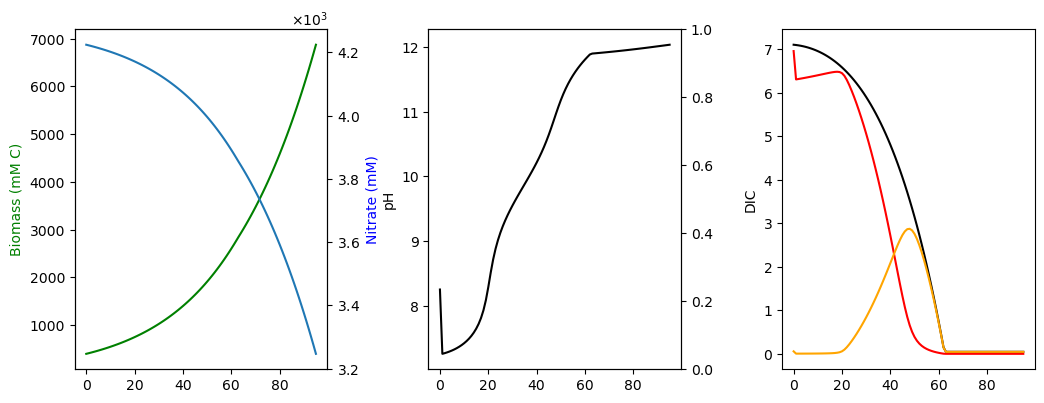

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12,4)) 

# Adjust spacing
fig.subplots_adjust(
    left=0.1,  # the left side of the subplots of the figure
    right=0.9, # the right side of the subplots of the figure
    bottom=0.1, # the bottom of the subplots of the figure
    top=0.95, # the top of the subplots of the figure
    wspace=0.4, # the width of the padding between subplots, as a fraction of the average axis width
    hspace=0.6 # the height of the padding between subplots, as a fraction of the average axis height
)

ax1.plot(df['Cphyto_total'], color='green')
ax1.set_ylabel('Biomass (mM C)', color='green')

ax1b = ax1.twinx()
ax1b.plot(df['nitrate_total'])
ax1b.set_xlabel('Hours')
ax1b.set_ylabel('Nitrate (mM)', color='blue')
ax1b.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True) 

ax2.plot(df['pH'], color='black')
ax2.set_ylabel('pH', color='black')
ax2b = ax2.twinx()
#ax2b.plot(df['bicarbonate_conc'], color='red')


ax3.plot(df['DIC'], color='black')
ax3.set_ylabel('DIC', color='black')
ax3.plot(df['bicarbonate_conc'], color='red')
ax3.plot(df['carbonate_conc'], color='orange')



0.18750000000000003


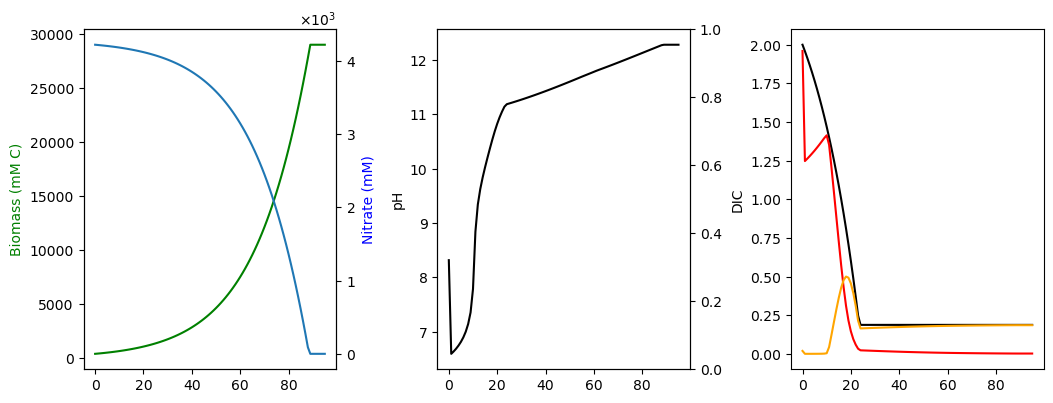

In [67]:
air_flow=40 # Standard liters per minute

df = bioreactor_run(PAR=200, Cphyto_init = 400, time=np.arange(0,96), air_flow=air_flow, umax = 1.2)
df

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12,4)) 

# Adjust spacing
fig.subplots_adjust(
    left=0.1,  # the left side of the subplots of the figure
    right=0.9, # the right side of the subplots of the figure
    bottom=0.1, # the bottom of the subplots of the figure
    top=0.95, # the top of the subplots of the figure
    wspace=0.4, # the width of the padding between subplots, as a fraction of the average axis width
    hspace=0.6 # the height of the padding between subplots, as a fraction of the average axis height
)

ax1.plot(df['Cphyto_total'], color='green')
ax1.set_ylabel('Biomass (mM C)', color='green')

ax1b = ax1.twinx()
ax1b.plot(df['nitrate_total'])
ax1b.set_xlabel('Hours')
ax1b.set_ylabel('Nitrate (mM)', color='blue')
ax1b.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True) 

ax2.plot(df['pH'], color='black')
ax2.set_ylabel('pH', color='black')
ax2b = ax2.twinx()
#ax2b.plot(df['bicarbonate_conc'], color='red')


ax3.plot(df['DIC'], color='black')
ax3.set_ylabel('DIC', color='black')
ax3.plot(df['bicarbonate_conc'], color='red')
ax3.plot(df['carbonate_conc'], color='orange')

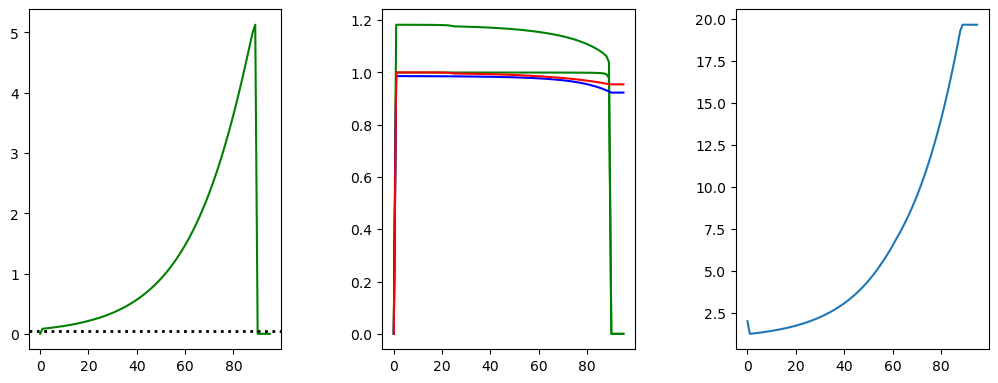

In [70]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12,4)) 

# Adjust spacing
fig.subplots_adjust(
    left=0.1,  # the left side of the subplots of the figure
    right=0.9, # the right side of the subplots of the figure
    bottom=0.1, # the bottom of the subplots of the figure
    top=0.95, # the top of the subplots of the figure
    wspace=0.4, # the width of the padding between subplots, as a fraction of the average axis width
    hspace=0.6 # the height of the padding between subplots, as a fraction of the average axis height
)

ax1.plot(df['dCphyto_dt'], color='green')
ax1.axhline(micromoles_of_CO2, color='black', linestyle='dotted', linewidth=2)

ax2.plot(df['growth_rate'], color='green')

ax2.plot(df['nutlim'], color='green')
ax2.plot(df['lightlim'], color='blue') 
ax2.plot(df['bicarbonate_lim'], color='red')

ax3.plot(df['TA'])

In [68]:
df.tail

<bound method NDFrame.tail of     Cphyto_total  Cphyto_conc  dCphyto_dt  growth_rate    nutlim  lightlim  \
0     400.000000     1.666667    0.000000     0.000000  0.000000  0.000000   
1     420.198682     1.750828    0.084161     1.182315  0.999526  0.985780   
2     441.416652     1.839236    0.088408     1.182278  0.999545  0.985759   
3     463.705526     1.932106    0.092870     1.182252  0.999545  0.985736   
4     487.119298     2.029664    0.097557     1.182224  0.999545  0.985713   
..           ...          ...         ...          ...       ...       ...   
91  29021.980182   120.924917    0.000000     0.000000  0.000000  0.922702   
92  29021.980182   120.924917    0.000000     0.000000  0.000000  0.922702   
93  29021.980182   120.924917    0.000000     0.000000  0.000000  0.922702   
94  29021.980182   120.924917    0.000000     0.000000  0.000000  0.922702   
95  29021.980182   120.924917    0.000000     0.000000  0.000000  0.922702   

    bicarbonate_lim        chl   

## Plot some physiology data

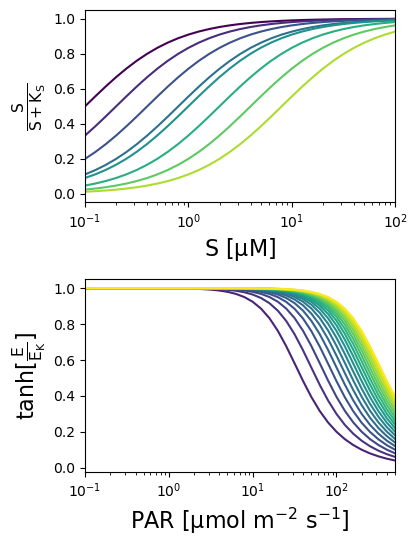

In [80]:
E = 10**np.arange(-2,3,0.1)
Ek = np.arange(20,210,10)

S =  10**np.arange(-2,3,0.1)
Ks = np.array([0.1,0.2,0.4,0.8,1,2,4,8])

cmap = cm.viridis
plt.rcParams['axes.labelsize'] = 16   
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(4,6))
fig.subplots_adjust(hspace=0.4, wspace=0.4) 

for i in Ek:
    light_response =  [1* i * math.tanh(x/i) for x in E]
    light_response_2 =  [1 * i * math.tanh(x/i)/x for x in E]
    line_color = cmap(i/200)
    #ax1.plot(E, light_response, color=line_color, label=f'Line with color from value {i:.1f}')
    #ax1.set_ylabel(r"$\mathrm{{\phi}_{PSII}^{max}~tanh[\frac{E}{E_{K}}]}$")
    #ax1.set_xlabel(r"$\mathrm{PAR~[{\mu}mol~m^{-2}~s^{-1}]}$")
    #ax1.set_xlim([0,500])
    
    ax2.plot(E, light_response/E, color=line_color, label=f'Line with color from value {i:.1f}')
    ax2.set_xscale('log') 
    ax2.set_xlim([0.1,500])
    ax2.set_ylabel(r"$\mathrm{tanh[\frac{E}{E_{K}}]}$")
    ax2.set_xlabel(r"$\mathrm{PAR~[{\mu}mol~m^{-2}~s^{-1}]}$")

for i,j in zip(Ks, range(9)):
    nutrient_response =  [x / (i + x) for x in S]
    nutrient_response_norm =  [x / (i + x)/x for x in S]
    # light_response_2 =  [0.65 * i * math.tanh(x/i)/x for x in E]
    line_color = cmap(j/8)
    ax1.plot(S, nutrient_response, color=line_color, label=f'Line with color from value {i:.1f}')
    ax1.set_ylabel(r"$\mathrm{\frac{S}{S+K_{S}}}$")
    ax1.set_xlabel(r"$\mathrm{S~[{\mu}M]}$")
    ax1.set_xscale('log') 
    ax1.set_xlim([0.1,100])
    
    #ax2.plot(S, nutrient_response_norm, color=line_color, label=f'Line with color from value {i:.1f}')
    #ax2.set_ylabel(r"$\mathrm{\frac{S}{S+K_{S}}}$")
    #ax2.set_xlabel(r"$\mathrm{S~[{\mu}M]}$")
    #ax2.set_xscale('log') 
    #ax2.set_xlim([0.1,100])
plt.savefig('resource limitation.png', dpi=150)    

## DIC, pH, Alkalinity

### (2.14) ALK = [HCO3] + 2[CO3] + [HPO4] + 2*[PO4] + [OH] - [H3PO4] - [H]
### (2.15) dALK/dt = D(ALKinit - ALK) + (muN + muP + 2*muS)X 
##### where X is population density of algae, muN, muP and MuS are uptake of Nitrogen, Phosphorus and Sulfur (assume Redfield)


In [100]:
TA = 2000

pH_range = np.arange(5,12.1,0.1)
TA_range= np.arange(2000,21000,500)
CO2 = np.zeros([len(pH_range), len(TA_range)])
HCO3 = np.zeros([len(pH_range), len(TA_range)])
CO3 = np.zeros([len(pH_range), len(TA_range)])
DIC = np.zeros([len(pH_range), len(TA_range)])


# Take a snapshot across PH scales
for i in range(len(pH_range)):
    for j in range(len(TA_range)):
        pyco2_results = pyco2.sys(par1=TA_range[j], par2=pH_range[i], par1_type=1,  par2_type=3, salinity=0, opt_k_carbonic=8, pressure=1)
        DIC[i,j] = pyco2_results['dic']
        CO2[i,j] = pyco2_results['aqueous_CO2']
        HCO3[i,j] = pyco2_results['bicarbonate']
        CO3[i,j] = pyco2_results['carbonate']



Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given t

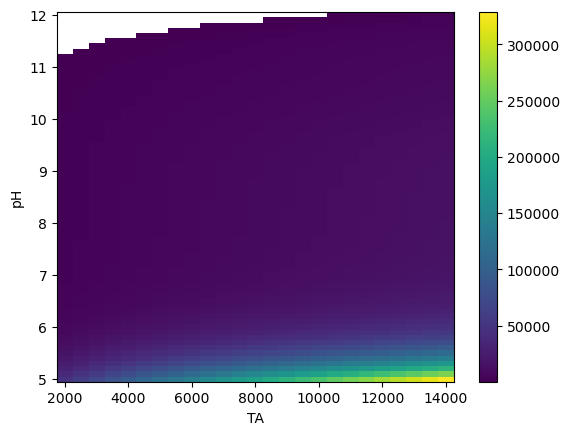

In [106]:
# Create the DataArray without coordinates initially
data_xr = xr.DataArray(DIC, dims=("pH", "TA") )
data_xr = data_xr.assign_coords(
    {"pH":pH_range, 
     "TA": TA_range}
)
data_xr.plot()

Text(11.8, 1.5, '$\\mathbf{CO_3^{-2}}$')

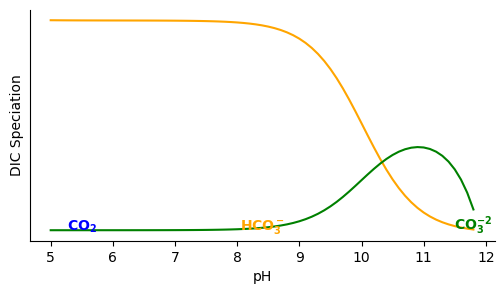

In [95]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(6,3))
fig.subplots_adjust(hspace=0.4, wspace=0.4) 

#ax1.plot(pH_range, CO2, color='blue')
ax1.plot(pH_range, HCO3, color='orange')
ax1.plot(pH_range, CO3, color='green')
ax1.set_xlabel('pH')
ax1.set_ylabel('DIC Speciation')
ax1.set_yticks([])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.text(5.5, 1.5, r'$\mathbf{CO_2}$', color='blue', fontweight='bold', ha='center')
ax1.text(8.4, 1.5,  r'$\mathbf{HCO_3^-}$', color='orange', fontweight='bold', ha='center')
ax1.text(11.8, 1.5,  r'$\mathbf{CO_3^{-2}}$', color='green', fontweight='bold', ha='center')

In [92]:
#pyco2.sys(par1=2000, par2=8.5, par1_type=1,  par2_type=3, salinity=0, opt_k_carbonic=8, pressure=1)
pyco2_results = pyco2.sys(par1=4000, par2=11.5, par1_type=1,  par2_type=3, salinity=0, opt_k_carbonic=8, pressure=1)
pyco2_results

{'par1': 4000.0,
 'par1_type': array(1),
 'par2': 11.5,
 'par2_type': array(3),
 'alkalinity': 4000.0,
 'dic': 412.1492248293088,
 'opt_k_bisulfate': 1,
 'opt_k_carbonic': 8,
 'opt_k_fluoride': 1,
 'opt_total_borate': 1,
 'opt_gas_constant': 3,
 'opt_pH_scale': 1,
 'opt_buffers_mode': 1,
 'salinity': array(0.),
 'temperature': 25.0,
 'pressure': 1.0,
 'total_ammonia': 0.0,
 'total_borate': 0.0,
 'total_calcium': 0.0,
 'total_fluoride': 0.0,
 'total_phosphate': 0.0,
 'total_silicate': 0.0,
 'total_sulfate': 0.0,
 'total_sulfide': 0.0,
 'peng_correction': 0.0,
 'gas_constant': array(83.14462618),
 'total_alpha': 0.0,
 'total_beta': 0.0,
 'pressure_atmosphere': 1.0,
 'pressure_atmosphere_out': 1.0,
 'opt_pressured_kCO2': 0,
 'opt_adjust_temperature': 1,
 'opt_which_fCO2_insitu': 1,
 'bh_upsilon': 28995.0,
 'pH': 11.5,
 'pCO2': 0.005456218320879349,
 'fCO2': 0.005438815388144019,
 'bicarbonate': 26.081345291988374,
 'carbonate': 386.06769428562563,
 'aqueous_CO2': 0.00018525169478595684,
 

In [74]:
df['TA'][0]

2.0

In [170]:

pH_init = 7.5
DIC_init = 2 *1000 #umol kg-1
alkalinity_init = 4.5 * 1000 # umol kg-1

results = pyco2.sys(par1=pH_init, par2=DIC_init, par1_type=3,  par2_type=2, salinity=0, 
                    total_silicate=0,
                    total_phosphate=220)
results

{'par1': 7.5,
 'par1_type': array(3),
 'par2': 2000.0,
 'par2_type': array(2),
 'alkalinity': 2090.569735518017,
 'dic': 2000.0,
 'opt_k_bisulfate': 1,
 'opt_k_carbonic': 10,
 'opt_k_fluoride': 1,
 'opt_total_borate': 1,
 'opt_gas_constant': 3,
 'opt_pH_scale': 1,
 'opt_buffers_mode': 1,
 'salinity': array(0.),
 'temperature': 25.0,
 'pressure': 0.0,
 'total_ammonia': 0.0,
 'total_borate': 0.0,
 'total_calcium': 0.0,
 'total_fluoride': 0.0,
 'total_phosphate': 219.99999999999997,
 'total_silicate': 0.0,
 'total_sulfate': 0.0,
 'total_sulfide': 0.0,
 'peng_correction': 0.0,
 'gas_constant': array(83.14462618),
 'total_alpha': 0.0,
 'total_beta': 0.0,
 'pressure_atmosphere': 1.0,
 'pressure_atmosphere_out': 1.0,
 'opt_pressured_kCO2': 0,
 'opt_adjust_temperature': 1,
 'opt_which_fCO2_insitu': 1,
 'bh_upsilon': 28995.0,
 'pH': 7.5,
 'pCO2': 2283.6049194059538,
 'fCO2': 2276.321225743182,
 'bicarbonate': 1901.2250360014466,
 'carbonate': 21.24110141593246,
 'aqueous_CO2': 77.53386258262086

In [98]:
results['pH']
alk = results['alkalinity']
dic = DIC_init
foo = pyco2.sys(par1=alk, par2=DIC_init-600+19*50*60/250, par1_type=1,  par2_type=2, salinity=0, opt_k_carbonic=8)
foo['pH']

8.936710384255617

In [114]:
foo = pyco2.sys(par1=4530, par2=2300, par1_type=1,  par2_type=2, salinity=0, opt_k_carbonic=8)
foo['pH']

10.74745881449106

par1                          4530.0
par1_type                          1
par2                          2300.0
par2_type                          2
alkalinity                    4530.0
                         ...        
fugacity_factor    0.996810440544739
vp_factor                   0.968755
fH                               1.0
k_alpha                          0.0
k_beta                           0.0
Length: 114, dtype: object

In [ ]:
'HCO3': 1866.2238619635616,
'CO3': 13.155496579173882,
'CO2': 120.62064145726447,

In [32]:
foo = xr.open_dataset('/media/gsilsbe/Expansion/S3/chlor_a/S3A_OLCI_ERRNT.20160428.L3m.DAY.CHL.chlor_a.9km.nc')
foo

<xarray.Dataset>
Dimensions:  (lat: 2160, lon: 4320, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon      (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a  (lat, lon) float32 ...
    palette  (rgb, eightbitcolor) uint8 ...
Attributes: (12/62)
    product_name:                     S3A_OLCI_ERRNT.20160428.L3m.DAY.CHL.chl...
    instrument:                       OLCI
    title:                            OLCIS3A Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Sentinel-3A
    source:                           satellite observations from OLCI-Sentin...
    ...                               ...
    cdm_data_type:                    grid
    keywords:                         Earth Science > Oceans > Ocean Chemistr...
    keywords_vocabulary:              NASA Global Change Master Directory (GC...
    data_bins:                        719101
    data_minimum:                     0.0031804212
    data_maximum:                     95.83712